In [99]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os


In [100]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 4


In [101]:
# Use EfficientNet's native preprocessing
def preprocess(image):
    return applications.efficientnet.preprocess_input(image)

In [102]:
# Data generators with proper preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess)

# Dataset loading - verify your directory structure matches class names
train_ds = train_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/Training',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_ds = val_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/Testing',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Verify class indices match your expectations
print("Class indices:", train_ds.class_indices)


Found 2297 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [103]:
# Improved model architecture
def create_model():
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Partial unfreezing for better adaptation
    base_model.trainable = True
    for layer in base_model.layers[:-8]:
        layer.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    # Lower learning rate with cosine decay
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=1e-4,
            decay_steps=len(train_ds)*EPOCHS
        )
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [104]:
# Enhanced callbacks
callbacks = [
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='accuracy',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    callbacks.EarlyStopping(
        monitor='loss',
        patience=8,
        restore_best_weights=True
    )
]

In [105]:
# Train the model
model = create_model()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15


2025-03-14 13:40:43.120247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


72/72 [==============================] - 36s 349ms/step - loss: 1.0955 - accuracy: 0.5725 - lr: 9.8937e-05
Epoch 2/15
72/72 [==============================] - 25s 352ms/step - loss: 0.7175 - accuracy: 0.7266 - lr: 9.5736e-05
Epoch 3/15
72/72 [==============================] - 25s 353ms/step - loss: 0.5880 - accuracy: 0.7797 - lr: 9.0536e-05
Epoch 4/15
72/72 [==============================] - 25s 350ms/step - loss: 0.5705 - accuracy: 0.7928 - lr: 8.3564e-05
Epoch 5/15
72/72 [==============================] - 27s 372ms/step - loss: 0.5002 - accuracy: 0.8202 - lr: 7.5126e-05
Epoch 6/15
72/72 [==============================] - 25s 349ms/step - loss: 0.4757 - accuracy: 0.8237 - lr: 6.5589e-05
Epoch 7/15
72/72 [==============================] - 25s 349ms/step - loss: 0.4536 - accuracy: 0.8346 - lr: 5.5371e-05
Epoch 8/15
72/72 [==============================] - 25s 346ms/step - loss: 0.4062 - accuracy: 0.8498 - lr: 4.4918e-05
Epoch 9/15
72/72 [==============================] - 26s 356ms/step 

In [106]:
# Save final model in optimized format
model.save('brain_tumor_classifier', save_format='tf')

INFO:tensorflow:Assets written to: brain_tumor_classifier/assets


INFO:tensorflow:Assets written to: brain_tumor_classifier/assets


In [107]:
# Convert to TensorFlow Lite for even smaller size (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('brain_tumor_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgfhco4d5/assets


INFO:tensorflow:Assets written to: /tmp/tmpgfhco4d5/assets
2025-03-14 13:48:57.817189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-14 13:48:57.817260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-14 13:48:57.817505: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgfhco4d5
2025-03-14 13:48:57.851075: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-14 13:48:57.851134: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgfhco4d5
2025-03-14 13:48:58.004618: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-03-14 13:48:58.698319: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgfhco4d5
2025-03-14 13:48:59.002783: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Found 394 images belonging to 4 classes.
13/13 [==============================] - 2s 63ms/step - loss: 1.1727 - accuracy: 0.6904

Test Accuracy: 69.04%
Test Loss: 1.1727
13/13 [==============================] - 2s 69ms/step


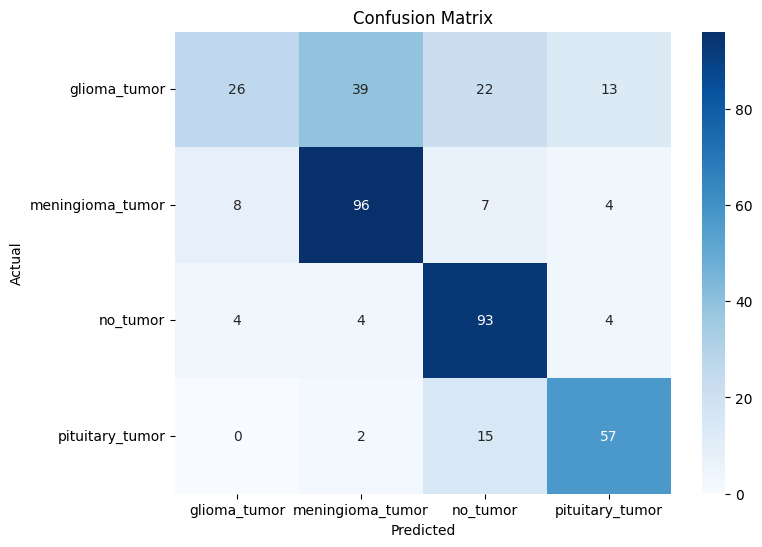

In [109]:
import seaborn as sns

# Load test dataset (separate from training/validation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess)
test_ds = test_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/Testing',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for correct label order
)

# Load best model
model = tf.keras.models.load_model('brain_tumor_classifier')

# 1. Calculate test accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# 2. Generate predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())

# 4. Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# 5. Visualize sample predictions
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    batch = test_ds[i % test_ds.batch_size]  # Get batch
    img = batch[0][0]  # First image in batch
    actual_label = class_labels[np.argmax(batch[1][0])]
    pred_label = class_labels[predicted_classes[i]]
    
    # De-normalize image for display
    img = (img * 255).astype('uint8')
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Detailed prediction analysis
correct = np.where(predicted_classes == true_classes)[0]
incorrect = np.where(predicted_classes != true_classes)[0]

print(f"\nCorrect Predictions: {len(correct)} ({len(correct)/len(true_classes):.2%})")
print(f"Incorrect Predictions: {len(incorrect)} ({len(incorrect)/len(true_classes):.2%})")

# Analyze top errors
if len(incorrect) > 0:
    print("\nTop 5 Error Cases:")
    for i in incorrect[:5]:
        print(f"Image {i}:")
        print(f"True: {class_labels[true_classes[i]]}")
        print(f"Predicted: {class_labels[predicted_classes[i]]}")
        print(f"Confidence: {np.max(predictions[i]):.2%}\n")